Sesión 15: Integración de Datos de Múltiples Fuentes
Demo 01: Operaciones Básicas de Merge

Este demo muestra las técnicas fundamentales para combinar datasets
utilizando operaciones de merge (inner, outer, left, right).

Autor: AdP Meridian Consulting
Fecha: 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## DEMO 01: OPERACIONES BÁSICAS DE MERGE

### 1. CARGA DE DATASETS INDIVIDUALES

In [3]:
# Cargar datos de producción
produccion = pd.read_csv('../datos/produccion_pozos.csv')
produccion['fecha'] = pd.to_datetime(produccion['fecha'])
print("✓ Datos de Producción cargados:")
print(f"  - Registros: {len(produccion)}")
print(f"  - Pozos únicos: {produccion['pozo_id'].nunique()}")
print(f"  - Período: {produccion['fecha'].min()} a {produccion['fecha'].max()}")
print()

✓ Datos de Producción cargados:
  - Registros: 35
  - Pozos únicos: 5
  - Período: 2024-01-01 00:00:00 a 2024-01-07 00:00:00



In [4]:
# Cargar datos de mantenimiento
mantenimiento = pd.read_csv('../datos/mantenimiento_equipos.csv')
mantenimiento['fecha_inicio'] = pd.to_datetime(mantenimiento['fecha_inicio'])
mantenimiento['fecha_fin'] = pd.to_datetime(mantenimiento['fecha_fin'])
print("✓ Datos de Mantenimiento cargados:")
print(f"  - Registros: {len(mantenimiento)}")
print(f"  - Pozos únicos: {mantenimiento['pozo_id'].nunique()}")
print(f"  - Tipos de equipo: {mantenimiento['equipo_tipo'].nunique()}")
print()

✓ Datos de Mantenimiento cargados:
  - Registros: 14
  - Pozos únicos: 5
  - Tipos de equipo: 7



### 2. EXPLORACIÓN DE CLAVES DE UNIÓN

In [5]:
# Identificar claves potenciales
print("Columnas en Producción:", list(produccion.columns))
print("Columnas en Mantenimiento:", list(mantenimiento.columns))
print()

Columnas en Producción: ['fecha', 'pozo_id', 'produccion_crudo_bpd', 'produccion_gas_mcf', 'presion_cabeza_psi', 'temperatura_c', 'activo']
Columnas en Mantenimiento: ['fecha_inicio', 'fecha_fin', 'pozo_id', 'equipo_tipo', 'descripcion_trabajo', 'costo_usd', 'duracion_horas', 'criticidad', 'responsable']



In [7]:
# Pozos comunes entre datasets
pozos_produccion = set(produccion['pozo_id'].unique())
pozos_mantenimiento = set(mantenimiento['pozo_id'].unique())
print("Análisis de pozos:")
print(f"  - Pozos en producción: {sorted(pozos_produccion)}")
print(f"  - Pozos en mantenimiento: {sorted(pozos_mantenimiento)}")
print(f"  - Pozos comunes: {sorted(pozos_produccion & pozos_mantenimiento)}")
print(f"  - Solo en producción: {sorted(pozos_produccion - pozos_mantenimiento)}")
print(f"  - Solo en mantenimiento: {sorted(pozos_mantenimiento - pozos_produccion)}")
print()

Análisis de pozos:
  - Pozos en producción: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']
  - Pozos en mantenimiento: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']
  - Pozos comunes: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']
  - Solo en producción: []
  - Solo en mantenimiento: []



### 3. MERGE POR POZO_ID (RELACIÓN MUCHOS A MUCHOS)

In [10]:
# Crear resumen de producción por pozo
prod_resumen = produccion.groupby('pozo_id').agg({
    'produccion_crudo_bpd': ['mean', 'sum', 'count'],
    'produccion_gas_mcf': ['mean', 'sum'],
    'presion_cabeza_psi': 'mean',
    'temperatura_c': 'mean',
    'activo': lambda x: x.sum() / len(x)  # Porcentaje de tiempo activo
}).round(2)
prod_resumen

produccion_crudo_bpd               produccion_gas_mcf         \
                        mean     sum count               mean    sum   
pozo_id                                                                
PZ001                 145.49  1018.4     7            1252.86   8770   
PZ002                  90.43   633.0     7             896.43   6275   
PZ003                 233.99  1637.9     7            2103.57  14725   
PZ004                 166.41  1164.9     7            1447.86  10135   
PZ005                  85.09   595.6     7             812.86   5690   

        presion_cabeza_psi temperatura_c   activo  
                      mean          mean <lambda>  
pozo_id                                            
PZ001               578.57         65.57     1.00  
PZ002               422.43         57.57     1.00  
PZ003               717.86         72.43     1.00  
PZ004               612.43         61.43     1.00  
PZ005               330.71         50.57     0.86

In [11]:
# Aplanar nombres de columnas
prod_resumen.columns = ['_'.join(col) for col in prod_resumen.columns]
prod_resumen = prod_resumen.reset_index()
prod_resumen.columns = ['pozo_id', 'crudo_promedio_bpd', 'crudo_total_bpd', 'dias_operacion',
                       'gas_promedio_mcf', 'gas_total_mcf', 'presion_promedio_psi',
                       'temperatura_promedio_c', 'porcentaje_activo']


In [12]:
print("✓ Resumen de producción por pozo:")
print(prod_resumen)

✓ Resumen de producción por pozo:
  pozo_id  crudo_promedio_bpd  crudo_total_bpd  dias_operacion  \
0   PZ001              145.49           1018.4               7   
1   PZ002               90.43            633.0               7   
2   PZ003              233.99           1637.9               7   
3   PZ004              166.41           1164.9               7   
4   PZ005               85.09            595.6               7   

   gas_promedio_mcf  gas_total_mcf  presion_promedio_psi  \
0           1252.86           8770                578.57   
1            896.43           6275                422.43   
2           2103.57          14725                717.86   
3           1447.86          10135                612.43   
4            812.86           5690                330.71   

   temperatura_promedio_c  porcentaje_activo  
0                   65.57               1.00  
1                   57.57               1.00  
2                   72.43               1.00  
3                   

In [14]:
# Crear resumen de mantenimiento por pozo
mant_resumen = mantenimiento.groupby('pozo_id').agg({
    'costo_usd': ['sum', 'count', 'mean'],
    'duracion_horas': 'sum',
    'criticidad': lambda x: (x == 'Alta').sum()
}).round(2)
mant_resumen

costo_usd                duracion_horas criticidad
              sum count     mean            sum   <lambda>
pozo_id                                                   
PZ001        2700     3   900.00             10          0
PZ002        4200     3  1400.00              8          0
PZ003        6750     3  2250.00             12          0
PZ004        1550     2   775.00              4          0
PZ005       26200     3  8733.33             25          3

In [15]:

mant_resumen.columns = ['costo_total_usd', 'eventos_mantenimiento', 'costo_promedio_usd',
                       'horas_mantenimiento_total', 'eventos_criticos']
mant_resumen = mant_resumen.reset_index()


In [16]:
print("✓ Resumen de mantenimiento por pozo:")
print(mant_resumen)

✓ Resumen de mantenimiento por pozo:
  pozo_id  costo_total_usd  eventos_mantenimiento  costo_promedio_usd  \
0   PZ001             2700                      3              900.00   
1   PZ002             4200                      3             1400.00   
2   PZ003             6750                      3             2250.00   
3   PZ004             1550                      2              775.00   
4   PZ005            26200                      3             8733.33   

   horas_mantenimiento_total  eventos_criticos  
0                         10                 0  
1                          8                 0  
2                         12                 0  
3                          4                 0  
4                         25                 3  


### 4. COMPARACIÓN DE TIPOS DE MERGE

#### Inner Join (solo pozos con datos en ambos datasets)


In [18]:
# Inner Join (solo pozos con datos en ambos datasets)
merge_inner = pd.merge(prod_resumen, mant_resumen, on='pozo_id', how='inner')
print(f"✓ INNER JOIN - Registros: {len(merge_inner)}")
print("  Pozos incluidos:", sorted(merge_inner['pozo_id'].tolist()))
print()

✓ INNER JOIN - Registros: 5
  Pozos incluidos: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']



#### Left Join (todos los pozos de producción)

In [17]:
merge_left = pd.merge(prod_resumen, mant_resumen, on='pozo_id', how='left')
print(f"✓ LEFT JOIN - Registros: {len(merge_left)}")
print("  Pozos incluidos:", sorted(merge_left['pozo_id'].tolist()))
print("  Valores nulos en mantenimiento:", merge_left[['costo_total_usd']].isnull().sum().sum())
print()

✓ LEFT JOIN - Registros: 5
  Pozos incluidos: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']
  Valores nulos en mantenimiento: 0



#### Right Join (todos los pozos de mantenimiento)

In [19]:
# Right Join (todos los pozos de mantenimiento)
merge_right = pd.merge(prod_resumen, mant_resumen, on='pozo_id', how='right')
print(f"✓ RIGHT JOIN - Registros: {len(merge_right)}")
print("  Pozos incluidos:", sorted(merge_right['pozo_id'].tolist()))
print()

✓ RIGHT JOIN - Registros: 5
  Pozos incluidos: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']



#### Outer Join (todos los pozos de ambos datasets)

In [20]:
merge_outer = pd.merge(prod_resumen, mant_resumen, on='pozo_id', how='outer')
print(f"✓ OUTER JOIN - Registros: {len(merge_outer)}")
print("  Pozos incluidos:", sorted(merge_outer['pozo_id'].tolist()))
print("  Valores nulos en producción:", merge_outer[['crudo_promedio_bpd']].isnull().sum().sum())
print("  Valores nulos en mantenimiento:", merge_outer[['costo_total_usd']].isnull().sum().sum())
print()

✓ OUTER JOIN - Registros: 5
  Pozos incluidos: ['PZ001', 'PZ002', 'PZ003', 'PZ004', 'PZ005']
  Valores nulos en producción: 0
  Valores nulos en mantenimiento: 0



### ===== ANÁLISIS DEL DATASET COMBINADO =====

### 5. ANÁLISIS DEL DATASET COMBINADO (INNER JOIN)

In [21]:
# Usar inner join para análisis
dataset_combinado = merge_inner.copy()
# Calcular métricas derivadas
dataset_combinado['costo_por_barril'] = (
    dataset_combinado['costo_total_usd'] / dataset_combinado['crudo_total_bpd']
).round(3)

dataset_combinado['eficiencia_operativa'] = (
    dataset_combinado['porcentaje_activo'] / 
    (dataset_combinado['eventos_mantenimiento'] + 1)
).round(3)

print("Dataset combinado con métricas derivadas:")
print(dataset_combinado[['pozo_id', 'crudo_promedio_bpd', 'costo_total_usd', 
                        'costo_por_barril', 'eficiencia_operativa']])
print()

Dataset combinado con métricas derivadas:
  pozo_id  crudo_promedio_bpd  costo_total_usd  costo_por_barril  \
0   PZ001              145.49             2700             2.651   
1   PZ002               90.43             4200             6.635   
2   PZ003              233.99             6750             4.121   
3   PZ004              166.41             1550             1.331   
4   PZ005               85.09            26200            43.989   

   eficiencia_operativa  
0                 0.250  
1                 0.250  
2                 0.250  
3                 0.333  
4                 0.215  



In [22]:
# Estadísticas del dataset combinado
print("Estadísticas del dataset combinado:")
print(f"  - Producción total: {dataset_combinado['crudo_total_bpd'].sum():,.0f} bpd")
print(f"  - Costo total mantenimiento: ${dataset_combinado['costo_total_usd'].sum():,.0f}")
print(f"  - Costo promedio por barril: ${dataset_combinado['costo_por_barril'].mean():.3f}")
print(f"  - Eficiencia operativa promedio: {dataset_combinado['eficiencia_operativa'].mean():.3f}")
print()

Estadísticas del dataset combinado:
  - Producción total: 5,050 bpd
  - Costo total mantenimiento: $41,400
  - Costo promedio por barril: $11.745
  - Eficiencia operativa promedio: 0.260



### 6. MERGE TEMPORAL (PRODUCCIÓN + EVENTOS)

In [ ]:
# Cargar datos de eventos
eventos = pd.read_csv('../datos/eventos_incidentes.csv')
eventos['fecha_evento'] = pd.to_datetime(eventos['fecha_evento'])

In [24]:
# Contar eventos por día y pozo
eventos_diarios = eventos.groupby(['fecha_evento', 'pozo_id']).agg({
    'tipo_evento': 'count',
    'severidad': lambda x: (x == 'Alta').sum()
}).rename(columns={
    'tipo_evento': 'eventos_total',
    'severidad': 'eventos_criticos'
}).reset_index()

In [25]:
eventos_diarios.rename(columns={'fecha_evento': 'fecha'}, inplace=True)

print("✓ Eventos agrupados por día:")
print(eventos_diarios.head())

✓ Eventos agrupados por día:
       fecha pozo_id  eventos_total  eventos_criticos
0 2024-01-01   PZ002              1                 0
1 2024-01-01   PZ003              1                 0
2 2024-01-01   PZ005              1                 1
3 2024-01-02   PZ001              1                 0
4 2024-01-02   PZ003              1                 0


In [26]:
# Merge temporal con producción diaria
prod_eventos = pd.merge(
    produccion, 
    eventos_diarios, 
    on=['fecha', 'pozo_id'], 
    how='left'
)

In [27]:
# Rellenar valores nulos (días sin eventos)
prod_eventos[['eventos_total', 'eventos_criticos']] = (
    prod_eventos[['eventos_total', 'eventos_criticos']].fillna(0)
)

In [28]:
print("✓ Dataset producción + eventos:")
print(f"  - Registros totales: {len(prod_eventos)}")
print(f"  - Días con eventos: {(prod_eventos['eventos_total'] > 0).sum()}")
print(f"  - Días con eventos críticos: {(prod_eventos['eventos_criticos'] > 0).sum()}")
print()

✓ Dataset producción + eventos:
  - Registros totales: 35
  - Días con eventos: 20
  - Días con eventos críticos: 2



In [29]:
# Análisis de correlación entre eventos y producción
correlacion = prod_eventos[['produccion_crudo_bpd', 'eventos_total', 'eventos_criticos']].corr()
print("Correlación entre producción y eventos:")
print(correlacion.round(3))
print()

Correlación entre producción y eventos:
                      produccion_crudo_bpd  eventos_total  eventos_criticos
produccion_crudo_bpd                 1.000         -0.118             0.108
eventos_total                       -0.118          1.000             0.213
eventos_criticos                     0.108          0.213             1.000



### 7. VISUALIZACIÓN DE RESULTADOS

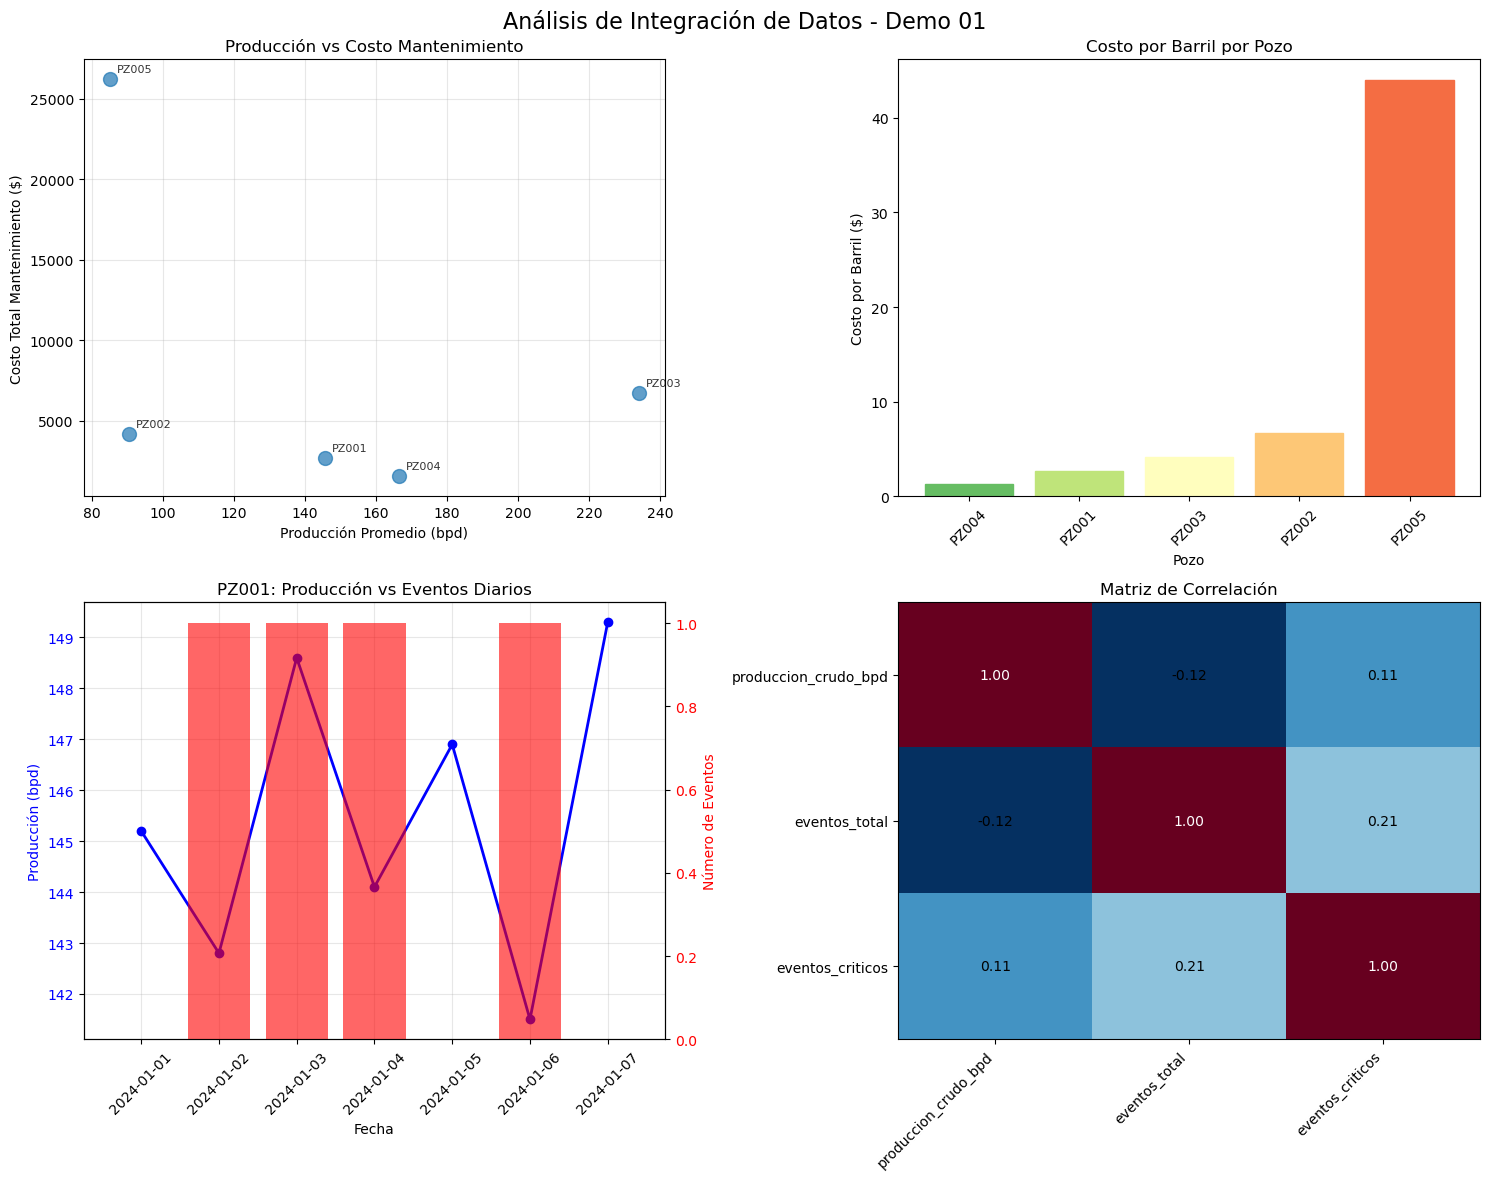

In [33]:
# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Integración de Datos - Demo 01', fontsize=16, y=0.98)
# Gráfico 1: Producción vs Costo de Mantenimiento
axes[0, 0].scatter(dataset_combinado['crudo_promedio_bpd'], 
                  dataset_combinado['costo_total_usd'], 
                  alpha=0.7, s=100)
axes[0, 0].set_xlabel('Producción Promedio (bpd)')
axes[0, 0].set_ylabel('Costo Total Mantenimiento ($)')
axes[0, 0].set_title('Producción vs Costo Mantenimiento')
axes[0, 0].grid(True, alpha=0.3)

# Agregar etiquetas de pozos
for idx, row in dataset_combinado.iterrows():
    axes[0, 0].annotate(row['pozo_id'], 
                       (row['crudo_promedio_bpd'], row['costo_total_usd']),
                       xytext=(5, 5), textcoords='offset points', 
                       fontsize=8, alpha=0.8)

# Gráfico 2: Costo por barril por pozo
dataset_combinado_sorted = dataset_combinado.sort_values('costo_por_barril')
bars = axes[0, 1].bar(dataset_combinado_sorted['pozo_id'], 
                     dataset_combinado_sorted['costo_por_barril'])
axes[0, 1].set_xlabel('Pozo')
axes[0, 1].set_ylabel('Costo por Barril ($)')
axes[0, 1].set_title('Costo por Barril por Pozo')
axes[0, 1].tick_params(axis='x', rotation=45)

# Colorear barras según valor
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Gráfico 3: Producción diaria con eventos
pz001_data = prod_eventos[prod_eventos['pozo_id'] == 'PZ001'].copy()
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

# Producción
line1 = ax3.plot(pz001_data['fecha'], pz001_data['produccion_crudo_bpd'], 
                'b-', marker='o', linewidth=2, label='Producción')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Producción (bpd)', color='b')
ax3.tick_params(axis='y', labelcolor='b')
ax3.tick_params(axis='x', rotation=45)

# Eventos
line2 = ax3_twin.bar(pz001_data['fecha'], pz001_data['eventos_total'], 
                    alpha=0.6, color='red', width=0.8, label='Eventos')
ax3_twin.set_ylabel('Número de Eventos', color='r')
ax3_twin.tick_params(axis='y', labelcolor='r')

ax3.set_title('PZ001: Producción vs Eventos Diarios')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Matriz de correlación
im = axes[1, 1].imshow(correlacion.values, cmap='RdBu_r', aspect='auto')
axes[1, 1].set_xticks(range(len(correlacion.columns)))
axes[1, 1].set_yticks(range(len(correlacion.index)))
axes[1, 1].set_xticklabels(correlacion.columns, rotation=45, ha='right')
axes[1, 1].set_yticklabels(correlacion.index)
axes[1, 1].set_title('Matriz de Correlación')

# Agregar valores de correlación
for i in range(len(correlacion.index)):
    for j in range(len(correlacion.columns)):
        text = axes[1, 1].text(j, i, f'{correlacion.iloc[i, j]:.2f}',
                              ha="center", va="center", color="white" if abs(correlacion.iloc[i, j]) > 0.5 else "black")

plt.tight_layout()

In [ ]:
plt.savefig('../datos/demo_01_resultados.png', dpi=300, bbox_inches='tight')
print("✓ Gráficos guardados en: ../datos/demo_01_resultados.png")
print()


### 8. EXPORTACIÓN DE RESULTADOS

In [ ]:
# Guardar datasets combinados
dataset_combinado.to_csv('../datos/produccion_mantenimiento_combinado.csv', index=False)
print("✓ Dataset combinado guardado: ../datos/produccion_mantenimiento_combinado.csv")

prod_eventos.to_csv('../datos/produccion_eventos_diarios.csv', index=False)
print("✓ Producción + eventos guardado: ../datos/produccion_eventos_diarios.csv")
print()

### 9. RESUMEN DE TÉCNICAS UTILIZADAS

In [35]:
# ===== RESUMEN Y CONCLUSIONES =====
print("9. RESUMEN DE TÉCNICAS UTILIZADAS")
print("-"*50)
print("✓ Técnicas de merge demostradas:")
print("  • Inner join: Solo registros con coincidencias en ambos datasets")
print("  • Left join: Todos los registros del dataset izquierdo")
print("  • Right join: Todos los registros del dataset derecho") 
print("  • Outer join: Todos los registros de ambos datasets")
print()
print("✓ Tipos de relaciones:")
print("  • Uno a uno: Pozo → Resumen de producción/mantenimiento")
print("  • Uno a muchos: Pozo → Múltiples eventos diarios")
print("  • Muchos a muchos: Fechas × Pozos (serie temporal)")
print()
print("✓ Claves de unión utilizadas:")
print("  • Clave simple: pozo_id")
print("  • Clave compuesta: fecha + pozo_id")
print()
print("✓ Métricas derivadas creadas:")
print("  • Costo por barril producido")
print("  • Eficiencia operativa")
print("  • Correlaciones entre variables")
print()

print("="*70)
print("DEMO 01 COMPLETADO - OPERACIONES BÁSICAS DE MERGE")
print("="*70)

9. RESUMEN DE TÉCNICAS UTILIZADAS
--------------------------------------------------
✓ Técnicas de merge demostradas:
  • Inner join: Solo registros con coincidencias en ambos datasets
  • Left join: Todos los registros del dataset izquierdo
  • Right join: Todos los registros del dataset derecho
  • Outer join: Todos los registros de ambos datasets

✓ Tipos de relaciones:
  • Uno a uno: Pozo → Resumen de producción/mantenimiento
  • Uno a muchos: Pozo → Múltiples eventos diarios
  • Muchos a muchos: Fechas × Pozos (serie temporal)

✓ Claves de unión utilizadas:
  • Clave simple: pozo_id
  • Clave compuesta: fecha + pozo_id

✓ Métricas derivadas creadas:
  • Costo por barril producido
  • Eficiencia operativa
  • Correlaciones entre variables

DEMO 01 COMPLETADO - OPERACIONES BÁSICAS DE MERGE
